In [35]:
%matplotlib inline

from collections import Counter
import pandas as pd
from functools import reduce
import csv

First, we'll read in the annotated data from the training set, and extract the headers

In [36]:
with open('../training-1-annotated.csv', newline='') as f:
    reader = csv.reader(f)
    lines = [l for l in reader]
data = pd.DataFrame(lines[1:], columns=lines[0])

lines = lines[1:]

We'll extract the statement references and their labels, then naively break those into words using whitespace so we can look at the distribution.

In [37]:
refs_and_labels = [(l[1],l[4]) for l in lines]
words = reduce(lambda a, b: a + b[0].split(), refs_and_labels, [])

Now we've got a single list of every occurence of every word in the dataset. It'd be useful to have the labels for these two, so we'll do a similar reduction over the list, replicating the reference's label according to the number of words in the row:

In [38]:
word_categories = reduce(lambda a, b: a + len(b[0].split())*[b[1]], refs_and_labels, [])

Now we'll count the words / labels so we can draw some handy histograms of the distribution of the words, and the per-word labels...

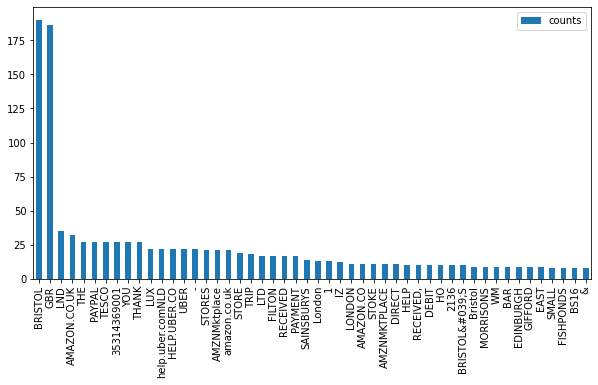

In [39]:
def plot_word_histogram(words, lim=None):
    word_counts = Counter(words)
    df_counts = pd.DataFrame.from_dict(word_counts, orient="index", columns = ["counts"])
    df_counts = df_counts.sort_values('counts',ascending=False)
    to_plot = df_counts if lim is None else df_counts[:lim]
    to_plot.plot(kind='bar',figsize=(10,5))

# Only plot the top 50 for the sake of readibility
plot_word_histogram(words, 50)


The dataset is pretty biased towards Bristol and GBR, but I guess that's not surprising as it appears in most of the transactions. Might be a pain later though...

Let's look at the distribution of per-word categories:

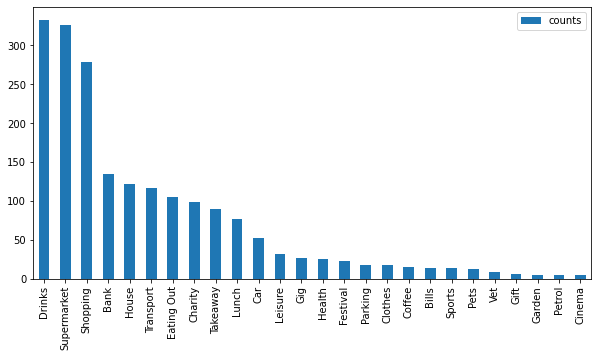

In [40]:
plot_word_histogram(word_categories)

Either I drink too much, or pubs tend to have more words per reference. Let's go with the latter...

Ok so that's interesting, but we can't do much with the raw words. [Facebook's FastText](https://fasttext.cc) algorithm should give us some quick and easy pre-trained embeddings so we can start doing something more interesting. The following is based on the embedding loader from [their website](https://fasttext.cc/docs/en/english-vectors.html).

Loading the full vocab takes a long time, and it's ordered by most common words first. We'll see if we can get away with a reduce vocab first...

In [41]:
import io
from tqdm.notebook import tqdm

# I've added a max-vocab size here as loading the whole 999995 entries is very slow.
# Maybe we don't need the whole vocab? (more on that later)
def load_vectors(fname, max_vocab=999995):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    vocab = [None] * max_vocab
    
    for v_count, line in enumerate(tqdm(fin, desc="Loading vocab from embeddings...", total=max_vocab)):
        if max_vocab is not None and v_count >= max_vocab:
            break
        tokens = line.rstrip().split(' ')
        
        vocab[v_count] = tokens[0]
    
    return vocab[:min(v_count, max_vocab)]

vocab_10k = load_vectors("../data/wiki-news-300d-1M.vec",10000)

Takes a while, but now we have a bunch of word embeddings so we might be able to do something useful with our data.

First, let's take a look at how many unknown tokens we have relative to others to make sure our reduced vocab hasn't broken anything.

To do this, we'll `import fasttext` and use the `tokenize()` method to convert our input into [compatible tokens](https://fasttext.cc/docs/en/python-module.html#important-preprocessing-data--encoding-conventions).

Then we'll run through all the descriptions and replace tokens that don't appear in the vocab, with an `<unk>` symbol to indicate they're unkown.

In [42]:
import fasttext

def tokenize_data(annotated_names, vocab):
    tokenised_data = [(fasttext.tokenize(x[0].lower()), x[1]) for x in annotated_names]
    tokenised_with_unknowns = [([x if x in vocab else '<unk>' for x in d[0]], d[1]) for d in tokenised_data]
    return tokenised_with_unknowns

tokenized_refs_and_labels = tokenize_data(refs_and_labels, vocab_10k)
tokenized_refs_and_labels[:5]

[(['02', 'academy', '<unk>', '<unk>', '<unk>'], 'Drinks'),
 (['28', '<unk>', 'place', '<unk>', '<unk>', '<unk>'], 'Drinks'),
 (['<unk>', 'miles', 'from', '<unk>', '<unk>'], 'Eating Out'),
 (['<unk>', 'miles', 'from', '<unk>', '<unk>'], 'Eating Out'),
 (['<unk>', 'insurance', '<unk>', '<unk>'], 'Car')]

Oof, doesn't look pretty. Lets get the full list of words out and checkout the token distribution...

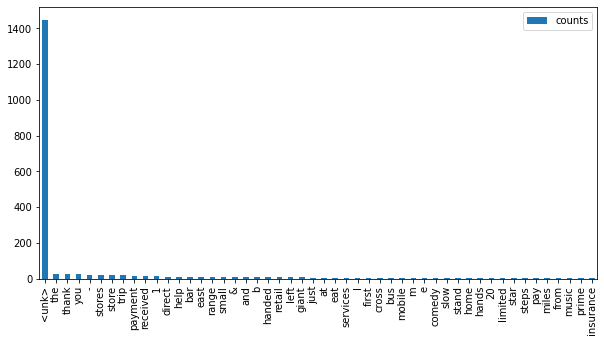

In [43]:
stacked_tokenized_refs = reduce(lambda x, y: x + y[0], tokenized_refs_and_labels, [])
plot_word_histogram(stacked_tokenized_refs, 50)

Hmm, not great, let's try some bigger vocabs...

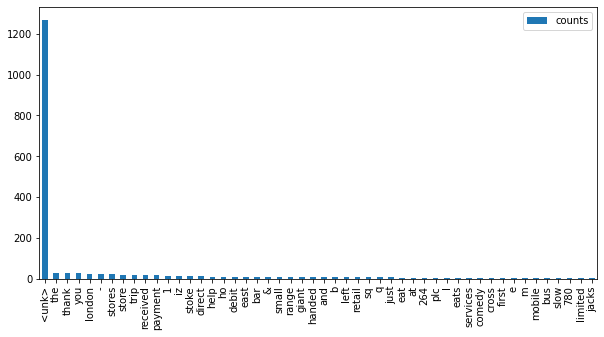

In [44]:
vocab_50k = load_vectors("../data/wiki-news-300d-1M.vec",50000)
tokenized_refs_and_labels = tokenize_data(refs_and_labels, vocab_50k)
stacked_tokenized_refs = reduce(lambda x, y: x + y[0], tokenized_refs_and_labels, [])
plot_word_histogram(stacked_tokenized_refs, 50)

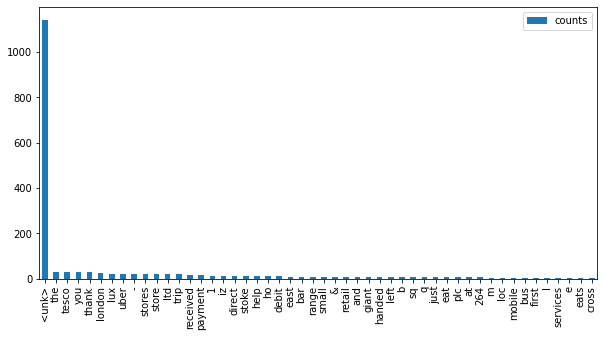

In [45]:
vocab_100k = load_vectors("../data/wiki-news-300d-1M.vec",100000)
tokenized_refs_and_labels = tokenize_data(refs_and_labels, vocab_100k)
stacked_tokenized_refs = reduce(lambda x, y: x + y[0], tokenized_refs_and_labels, [])
plot_word_histogram(stacked_tokenized_refs, 50)

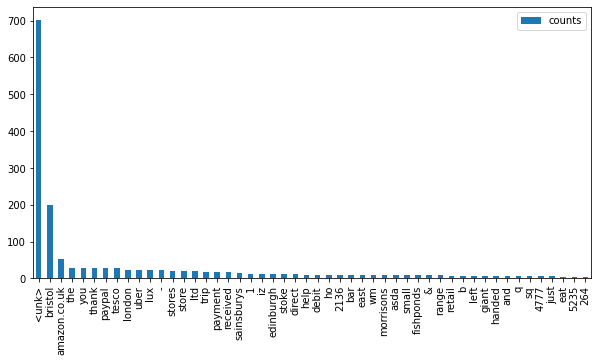

In [46]:
vocab_500k = load_vectors("../data/wiki-news-300d-1M.vec",500000)
tokenized_refs_and_labels = tokenize_data(refs_and_labels, vocab_500k)
stacked_tokenized_refs = reduce(lambda x, y: x + y[0], tokenized_refs_and_labels, [])
plot_word_histogram(stacked_tokenized_refs, 50)

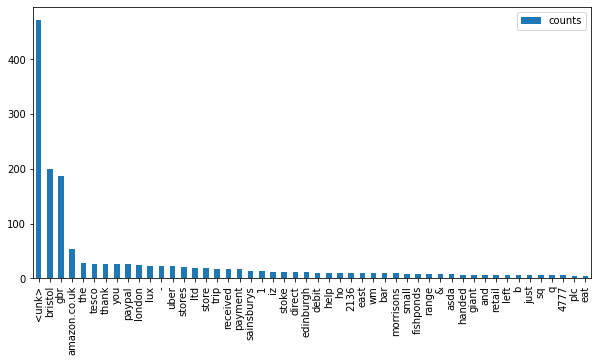

In [47]:
vocab_full = load_vectors("../data/wiki-news-300d-1M.vec")
tokenized_refs_and_labels = tokenize_data(refs_and_labels, vocab_full)
stacked_tokenized_refs = reduce(lambda x, y: x + y[0], tokenized_refs_and_labels, [])
plot_word_histogram(stacked_tokenized_refs, 50)

Even with the full vocab, we've got a lot of unknown tokens! This makes life difficult if we want a lightweight model (and I do, because I haven't got a very good GPU).

So what's going on here?

Let's look at an entry with lots of unknowns...

In [48]:
tokenized_refs_and_labels[-5]

(['<unk>', '<unk>', '0208', '<unk>'], 'Takeaway')

What does this relate too in terms of the original text?

In [49]:
refs_and_labels[-5]

('WWW.JUST EAT.CO.UK       0208 7362006', 'Takeaway')

Huh - standard Saturday night takeaway. It seems like "Just Eat" should be pretty readible... But the nice easy words we're expecting have got artefacts on them we don't want - I don't care about as much a
bout the `WWW.` and the `.CO.UK`, as I do about the words "Just" and "Eat".

So it looks like I jumped the gun here. I shouldn't have tokenised the raw data - it needs cleaning first.

For the sake of clarity, lets look at the tokenisation of the manually annotated vendor names:

In [50]:
def get_word_histogram_for_vocab(vocab, words, lim=None):
    token_data = tokenize_data(words, vocab)
    stacked_tokenized_refs = reduce(lambda x, y: x + y[0], token_data, [])
    word_counts = Counter(stacked_tokenized_refs)
    df_counts = pd.DataFrame.from_dict(word_counts, orient="index", columns = ["counts"])
    df_counts = df_counts.sort_values('counts',ascending=False)
    return df_counts if lim is None else df_counts[:lim]

vocabs = (vocab_10k, vocab_50k, vocab_100k, vocab_500k, vocab_full)

<AxesSubplot:>

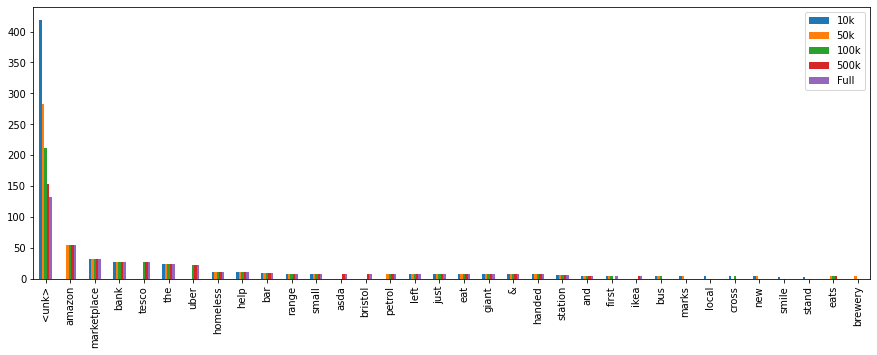

In [51]:
all_counts =[get_word_histogram_for_vocab(v, zip(data['Vendor'], data['Category']), 25) for v in vocabs]
all_counts_df = pd.concat(all_counts, axis=1)
all_counts_df.columns=("10k", "50k", "100k", "500k", "Full")
all_counts_df = all_counts_df.sort_values('Full',ascending=False)
all_counts_df.plot(kind='bar', figsize=(15,5))

Ok, so looking at this, we've still got a lot of unkowns with a small vocab, but a lot less than with unsantised data.

We also see the number of unknows dropping quickly as we decrease the vocab size. Let's compare that to the unsanitised data:

<AxesSubplot:>

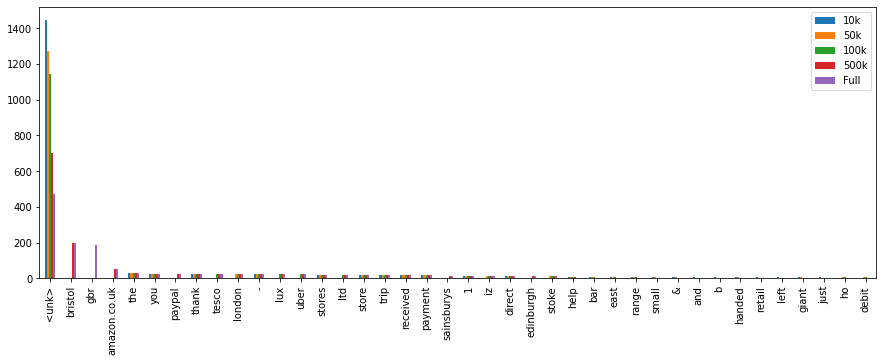

In [67]:
all_counts =[get_word_histogram_for_vocab(v, refs_and_labels, 25) for v in vocabs]
all_counts_df = pd.concat(all_counts, axis=1)
all_counts_df.columns=("10k", "50k", "100k", "500k", "Full")
all_counts_df = all_counts_df.sort_values('Full',ascending=False)
all_counts_df.plot(kind='bar', figsize=(15,5))

TBC...

In [68]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ianhales/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ianhales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [74]:
import re
from nltk.stem import WordNetLemmatizer


stemmer = WordNetLemmatizer()
en_stop = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text


<AxesSubplot:>

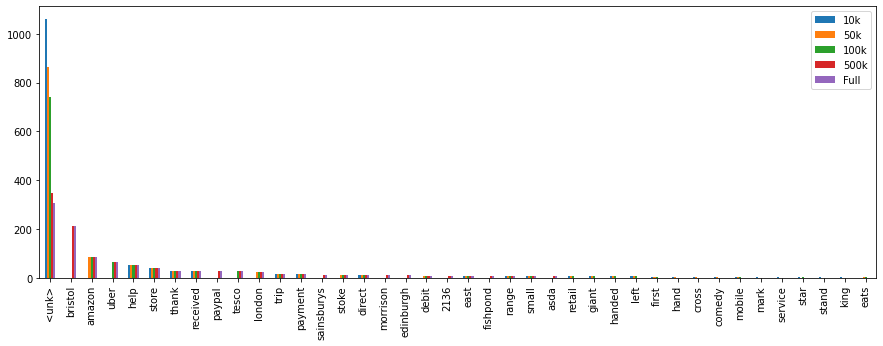

In [75]:
pre_processed = [(preprocess_text(r), l)for r, l in refs_and_labels]
all_counts =[get_word_histogram_for_vocab(v, pre_processed, 25) for v in vocabs]
all_counts_df = pd.concat(all_counts, axis=1)
all_counts_df.columns=("10k", "50k", "100k", "500k", "Full")
all_counts_df = all_counts_df.sort_values('Full',ascending=False)
all_counts_df.plot(kind='bar', figsize=(15,5))

<AxesSubplot:>

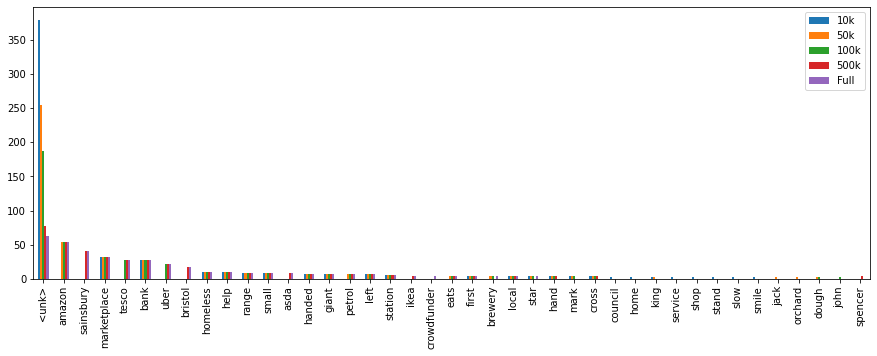

In [76]:
pre_processed = [(preprocess_text(r), l)for r, l in zip(data['Vendor'], data['Category'])]
all_counts =[get_word_histogram_for_vocab(v, pre_processed, 25) for v in vocabs]
all_counts_df = pd.concat(all_counts, axis=1)
all_counts_df.columns=("10k", "50k", "100k", "500k", "Full")
all_counts_df = all_counts_df.sort_values('Full',ascending=False)
all_counts_df.plot(kind='bar', figsize=(15,5))

In [77]:
pre_processed

[('academy bristol', 'Drinks'),
 ('york place', 'Drinks'),
 ('4500 mile delhi', 'Eating Out'),
 ('4500 mile delhi', 'Eating Out'),
 ('admiral', 'Car'),
 ('alchemy', 'Drinks'),
 ('aldi', 'Supermarket'),
 ('aldi', 'Supermarket'),
 ('aldi', 'Supermarket'),
 ('aldi', 'Supermarket'),
 ('', 'Drinks'),
 ('allerdale borough council', 'Parking'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon', 'Shopping'),
 ('amazon marketplace', 'Shopping'),
 ('amazon marketplace', 'Shopping'),
 ('amazon marketplace', 'Shopping'),